# Chatbot with a tensorflow transformer

In [ ]:
!pip install "tensorflow-text"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 40.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_text as tf_text
import numpy as np
import re
import tensorflow as tf
from typing import Tuple
import matplotlib.pyplot as plt

## Data processing functions and tokenizers

In [ ]:
def parse_dialogues(file_path: str) -> Tuple[np.ndarray, np.ndarray]:
    contexts = []
    targets = []

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()

            if line == '':
                continue

            if line.endswith('__eou__'):
                sentences = line.split('__eou__')
                sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

                for i in range(len(sentences) - 1):
                    contexts.append(sentences[i])
                    targets.append(sentences[i+1])

    # Convert lists to numpy arrays
    contexts = np.array(contexts)
    targets = np.array(targets)

    return targets, contexts

In [ ]:
def tf_lower_and_split_punct(sentence: tf.Tensor) -> tf.Tensor:
    sentence = tf.strings.lower(sentence)
    sentence = tf.strings.strip(sentence)

    sentence = tf.strings.regex_replace(sentence, r"([?.!,])", r" \1 ")
    sentence = tf.strings.regex_replace(sentence, r'[" "]+', " ")

    sentence = tf.strings.regex_replace(sentence, r"i'm", "i am")
    sentence = tf.strings.regex_replace(sentence, r"he's", "he is")
    sentence = tf.strings.regex_replace(sentence, r"she's", "she is")
    sentence = tf.strings.regex_replace(sentence, r"it's", "it is")
    sentence = tf.strings.regex_replace(sentence, r"that's", "that is")
    sentence = tf.strings.regex_replace(sentence, r"what's", "that is")
    sentence = tf.strings.regex_replace(sentence, r"where's", "where is")
    sentence = tf.strings.regex_replace(sentence, r"how's", "how is")

    sentence = tf.strings.regex_replace(sentence, r"\'ll", " will")
    sentence = tf.strings.regex_replace(sentence, r"\'ve", " have")
    sentence = tf.strings.regex_replace(sentence, r"\'re", " are")
    sentence = tf.strings.regex_replace(sentence, r"\'d", " would")
    sentence = tf.strings.regex_replace(sentence, r"\'re", " are")

    sentence = tf.strings.regex_replace(sentence, r"won't", "will not")
    sentence = tf.strings.regex_replace(sentence, r"can't", "cannot")
    sentence = tf.strings.regex_replace(sentence, r"n't", " not")
    sentence = tf.strings.regex_replace(sentence, r"n'", "ng")
    sentence = tf.strings.regex_replace(sentence, r"'bout", "about")

    sentence = tf.strings.regex_replace(sentence, r"[^a-zA-Z?.!,]+", " ")
    sentence = tf.strings.strip(sentence)

    sentence = tf.strings.join(['[START]', sentence, '[END]'], separator=' ')

    return sentence

In [ ]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
target_raw, context_raw = parse_dialogues('/content/drive/MyDrive/dialogues_text.txt')

In [ ]:
print(f"Context length : {len(context_raw)}")
print(f"Target length  : {len(target_raw)}")

Context length : 89862
Target length  : 89862


In [ ]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)
val_raw = (tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

In [ ]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(standardize=tf_lower_and_split_punct,
                                                           max_tokens=max_vocab_size,
                                                           ragged=True)

target_text_processor = tf.keras.layers.TextVectorization(standardize=tf_lower_and_split_punct,
                                                          max_tokens=max_vocab_size,
                                                          ragged=True)

In [ ]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))
target_text_processor.adapt(train_raw.map(lambda context, target: target))

In [ ]:
train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

## Positional embedding

In [ ]:
def positional_encoding(length: int, depth: int) -> tf.Tensor:
    depth = depth / 2

    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :] / depth

    angle_rates = np.divide(1, np.power(10000, depths))
    angle_rads = np.matmul(positions, angle_rates)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis = -1
    )

    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(
        vocab_size,
        d_model,
        mask_zero=True
    )
    self.pos_encoding = positional_encoding(
        length=2048,
        depth=d_model
    )

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

## Attention layers

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()

    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    return x

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True
    )

    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x
    )

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask=True
    )

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

## FFN with ReLU activation function

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()

    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation="relu"),
        tf.keras.layers.Dense(d_model),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)

    return x

## Encoder build

### Single layer

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate
    )

    self.ffn = FeedForward(
        d_model,
        dff
    )

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)

    return x

### Encoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size,
        d_model=d_model
    )

    self.enc_layers = [
        EncoderLayer(
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            dropout_rate=dropout_rate
        )

        for _ in range(num_layers)
    ]

    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    x = self.pos_embedding(x)
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x

## Decoder build

### Single layer

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, d_model, num_heads,
               dff, dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate
    )

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate
    )

    self.ffn = FeedForward(
        d_model,
        dff
    )

  def call(self, x, context):
    x = self.causal_self_attention(x)
    x = self.cross_attention(x, context)

    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)

    return x

### Decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size,
        d_model=d_model
    )

    self.dropout = tf.keras.layers.Dropout(
        dropout_rate
    )

    self.dec_layers = [
        DecoderLayer(
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            dropout_rate=dropout_rate
        )

        for _ in range(num_layers)
    ]

    self.last_attn_scores = None

  def call(self, x, context):
    x = self.pos_embedding(x)
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    return x

## Transformer

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()

    self.encoder = Encoder(
        num_layers=num_layers, d_model=d_model,
        num_heads=num_heads, dff=dff,
        vocab_size=input_vocab_size,
        dropout_rate=dropout_rate
    )

    self.decoder = Decoder(
        num_layers=num_layers, d_model=d_model,
        num_heads=num_heads, dff=dff,
        vocab_size=target_vocab_size,
        dropout_rate=dropout_rate
    )

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    context, x = inputs

    context = self.encoder(context)

    x = self.decoder(x, context)

    logits = self.final_layer(x)

    try:
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

## Model build

### hyper parameters

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

### transformer initialization

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(context_text_processor.get_vocabulary()),
    target_vocab_size=len(target_text_processor.get_vocabulary()),
    dropout_rate=dropout_rate
)

### custom learning rate schedule

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = tf.cast(d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def get_config(self):
    return {'d_model': self.d_model, 'warmup_steps': self.warmup_steps}

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

### loss function and accuracy metric definition

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match_ = label == pred

  mask = label != 0

  match_ = match_ & mask

  match_ = tf.cast(match_, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match_)/tf.reduce_sum(mask)

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

### training

In [ ]:
history = transformer.fit(train_ds,
                epochs=20,
                validation_data=val_ds)

Epoch 1/20
1124/1124 [==============================] - 294s 223ms/step - loss: 5.4748 - masked_accuracy: 0.1992 - val_loss: 4.1200 - val_masked_accuracy: 0.2816
Epoch 2/20
1124/1124 [==============================] - 201s 179ms/step - loss: 3.9608 - masked_accuracy: 0.2934 - val_loss: 3.7816 - val_masked_accuracy: 0.3101
Epoch 3/20
1124/1124 [==============================] - 198s 176ms/step - loss: 3.7288 - masked_accuracy: 0.3109 - val_loss: 3.6536 - val_masked_accuracy: 0.3182
Epoch 4/20
1124/1124 [==============================] - 192s 170ms/step - loss: 3.6034 - masked_accuracy: 0.3197 - val_loss: 3.5325 - val_masked_accuracy: 0.3276
Epoch 5/20
1124/1124 [==============================] - 192s 171ms/step - loss: 3.4569 - masked_accuracy: 0.3324 - val_loss: 3.4569 - val_masked_accuracy: 0.3360
Epoch 6/20
1124/1124 [==============================] - 190s 169ms/step - loss: 3.3303 - masked_accuracy: 0.3445 - val_loss: 3.3836 - val_masked_accuracy: 0.3447
Epoch 7/20
1124/1124 [======

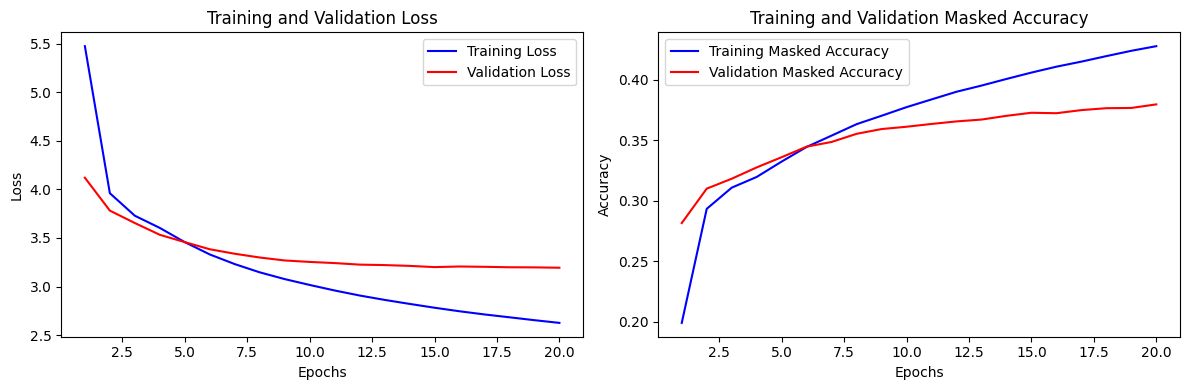

In [ ]:
# Extract the relevant metrics from the history object
train_loss = history.history['loss']
train_masked_acc = history.history['masked_accuracy']
val_loss = history.history['val_loss']
val_masked_acc = history.history['val_masked_accuracy']

# Plot the metrics per epoch
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))

# Plot training loss and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training masked accuracy and validation masked accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_masked_acc, 'b', label='Training Masked Accuracy')
plt.plot(epochs, val_masked_acc, 'r', label='Validation Masked Accuracy')
plt.title('Training and Validation Masked Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Chatbot

In [ ]:
MAX_TOKENS = 20

class Chatbot(tf.Module):
    def __init__(self, context_text_processor, target_text_processor, transformer):
        self.context_tokenizer = context_text_processor
        self.target_tokenizer = target_text_processor
        self.transformer = transformer

    def __call__(self, sentence, max_length=MAX_TOKENS):
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]

        sentence = self.context_tokenizer(sentence).to_tensor()

        encoder_input = sentence

        start_end = self.target_tokenizer([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer([encoder_input, output], training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

            predicted_id = tf.argmax(predictions, axis=-1)

            # Terminate if the predicted ID is the end token.
            if tf.reduce_all(tf.equal(predicted_id, end)):
                break

            # Write the predicted ID to the output array.
            output_array = output_array.write(i + 1, predicted_id[0])

        # Convert the output array to a tensor and remove the batch dimension.
        output = output_array.stack()
        output = tf.squeeze(output, axis=1)

        # Convert token IDs to text.
        predicted_sentence = [self.target_tokenizer.get_vocabulary()[token_id] for token_id in output.numpy()]

        # Remove the start and end tokens from the predicted sentence.
        predicted_sentence = predicted_sentence[1:-1]

        return predicted_sentence


## Testing

In [ ]:
chatbot = Chatbot(
    context_text_processor, target_text_processor, transformer
)

In [ ]:
def postprocess_response(response):
    # Remove [UNK] tokens
    # response = response.replace("[UNK]", "")

    # Capitalize the first letter of the response
    response = response.capitalize()

    # Add punctuation at the end of the response
    if not response.endswith((".", "!", "?")):
        response += "."

    # Capitalize after each punctuation mark
    response = re.sub(r'([.!?]\s*)(\w+)', lambda m: m.group(1) + m.group(2).capitalize(), response)

    return response

In [ ]:
def get_response(message):
    message = chatbot(tf.constant([message]))
    message = postprocess_response(" ".join(message))
    print(message)

In [ ]:
prompts = [
    "What did you have for breakfast today?",
    "Have you seen any interesting movies lately?",
    "Tell me about the last book you read.",
    "Did you meet any new people recently?",
    "What is your favorite place to hang out?",
    "Have you tried any new recipes recently?",
    "Tell me about a funny incident that happened to you.",
    "What is your favorite outdoor activity?",
    "Did you learn something new today?",
    "Describe your morning routine.",
    "What is your favorite way to relax after a long day?",
    "Tell me about a recent achievement or accomplishment.",
    "Have you visited any new restaurants or cafes?",
    "What is your favorite exercise or physical activity?",
    "Did you discover any new music or songs recently?",
    "Tell me about a project you're currently working on.",
    "What is the most interesting thing you've learned this week?",
    "Describe a place you would love to travel to and why.",
    "Have you attended any events or concerts recently?",
    "Tell me about a recent act of kindness you witnessed or performed."
]

In [ ]:
for prompt in prompts:
  print(prompt)
  get_response(prompt)

What did you have for breakfast today?
I went to the gym at the airport.
Have you seen any interesting movies lately?
Yes , i have.
Tell me about the last book you read.
I am afraid i am not interested in it.
Did you meet any new people recently?
Yes , i did.
What is your favorite place to hang out?
I am not sure.
Have you tried any new recipes recently?
Yes , i do . I am going to try to find a new dress.
Tell me about a funny incident that happened to you.
I did not know that.
What is your favorite outdoor activity?
I am not sure.
Did you learn something new today?
Yes , i did.
Describe your morning routine.
I am from [unk].
What is your favorite way to relax after a long day?
I do not know . I do not know.
Tell me about a recent achievement or accomplishment.
I am sure we will do well.
Have you visited any new restaurants or cafes?
I do not know . I do not know.
What is your favorite exercise or physical activity?
I am studying at the university entrance exam.
Did you discover any ne